In [51]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, LSTM, GRU, Dropout
from tensorflow.keras.optimizers import RMSprop, Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [52]:
# Cargar el archivo CSV
df = pd.read_csv('bitcoin.csv')

# Mostrar las primeras filas del DataFrame
df.head()

,Fecha,Ultimo,Apertura,Maximo,Minimo,Vol.,% var.
0,25.03.2025,"87.404,0","87.495,3","88.523,3","86.328,5","75,24K","-0,10%"
1,24.03.2025,"87.490,0","86.076,1","88.740,2","85.541,6","95,71K","1,64%"
2,23.03.2025,"86.077,4","83.840,2","86.082,0","83.812,7","31,13K","2,67%"
3,22.03.2025,"83.840,5","84.076,6","84.526,3","83.688,2","20,84K","-0,28%"
4,21.03.2025,"84.073,3","84.208,7","84.831,0","83.215,9","42,80K","-0,16%"


In [53]:
print(df.describe())

             Fecha    Ultimo  Apertura    Maximo    Minimo    Vol.  % var.
count         1854      1854      1854      1854      1854    1854    1854
unique        1854      1850      1849      1850      1853    1783     907
top     25.03.2025  21.517,2  19.793,4  57.697,4  34.357,4  56,24K  -0,08%
freq             1         2         2         2         2       3       8


In [54]:
df.isna().sum()

Fecha       0
Ultimo      0
Apertura    0
Maximo      0
Minimo      0
Vol.        0
% var.      0
dtype: int64

In [55]:
# Fijar la semilla para reproducibilidad
seed_value = 42
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

In [56]:
# Replace commas with dots and convert columns to float
columns_to_convert = ['Ultimo', 'Apertura', 'Maximo', 'Minimo']
for column in columns_to_convert:
    df[column] = df[column].str.replace('.', '', regex=False).str.replace(',', '.').astype(float)

In [57]:
# Ordenar los datos por fecha
df['Fecha'] = pd.to_datetime(df['Fecha'], dayfirst=True)
df = df.sort_values('Fecha')

In [58]:
# Ordenar los datos por fecha (si no lo están ya)
df['Fecha'] = pd.to_datetime(df['Fecha'], dayfirst=True)
df = df.sort_values('Fecha')
print(df['Fecha'])

1853   2020-02-26
1852   2020-02-27
1851   2020-02-28
1850   2020-02-29
1849   2020-03-01
          ...    
4      2025-03-21
3      2025-03-22
2      2025-03-23
1      2025-03-24
0      2025-03-25
Name: Fecha, Length: 1854, dtype: datetime64[ns]


In [59]:
# Utilizamos solo la columna del precio de cierre
data = df['Ultimo'].values.reshape(-1,1)

In [60]:
# Escalado de datos
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

In [61]:
# Crear secuencias para el entrenamiento
def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data[i:i+n_steps])
        y.append(data[i+n_steps])
    return np.array(X), np.array(y)

# Probar con distintos tamaños de ventana
n_steps = 50  # itera probando distintos valoreses 
X, y = create_sequences(scaled_data, n_steps)

# Dividir en entrenamiento y test (por ejemplo, 80-20)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [62]:
# Modelo Secuencial con LSTM o GRU
def build_sequential_model(model_type='LSTM', n_steps=5, n_features=1, n_units=50, n_layers=1, optimizer='rmsprop'):
    model = Sequential()
    # Agregar la primera capa con la especificación de input_shape
    if model_type == 'LSTM':
        model.add(LSTM(n_units, return_sequences=(n_layers > 1), input_shape=(n_steps, n_features)))
    elif model_type == 'GRU':
        model.add(GRU(n_units, return_sequences=(n_layers > 1), input_shape=(n_steps, n_features)))
    else:
        raise ValueError("Tipo de modelo no soportado")
    
    # Agregar capas ocultas adicionales, si se especifica
    for _ in range(n_layers - 1):
        if model_type == 'LSTM':
            model.add(LSTM(n_units, return_sequences=True))
        else:
            model.add(GRU(n_units, return_sequences=True))
        model.add(Dropout(0.2))  # opción para regularizar

    # Capa final de salida
    model.add(Dense(1))
    
    # Seleccionar optimizador
    if optimizer.lower() == 'rmsprop':
        opt = RMSprop()
    elif optimizer.lower() == 'adam':
        opt = Adam()
    else:
        raise ValueError("Optimizador no soportado")
        
    model.compile(optimizer=opt, loss='mae')
    return model

In [63]:
# Modelo Funcional con LSTM
def build_functional_model(model_type='LSTM', n_steps=50, n_features=1, n_units=50, n_layers=1, optimizer='rmsprop'):
    inputs = Input(shape=(n_steps, n_features))
    x = inputs
    # Primera capa
    if model_type == 'LSTM':
        x = LSTM(n_units, return_sequences=(n_layers > 1))(x)
    elif model_type == 'GRU':
        x = GRU(n_units, return_sequences=(n_layers > 1))(x)
    else:
        raise ValueError("Tipo de modelo no soportado")
    
    # Capas ocultas adicionales
    for _ in range(n_layers - 1):
        if model_type == 'LSTM':
            x = LSTM(n_units, return_sequences=True)(x)
        else:
            x = GRU(n_units, return_sequences=True)(x)
        x = Dropout(0.2)(x)
    
    outputs = Dense(1)(x)
    
    model = Model(inputs, outputs)
    
    # Seleccionar optimizador
    if optimizer.lower() == 'rmsprop':
        opt = RMSprop()
    elif optimizer.lower() == 'adam':
        opt = Adam()
    else:
        raise ValueError("Optimizador no soportado")
        
    model.compile(optimizer=opt, loss='mae')
    return model

/home/alumnadotarde/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
MAE modelo secuencial LSTM: 0.000754339052062441


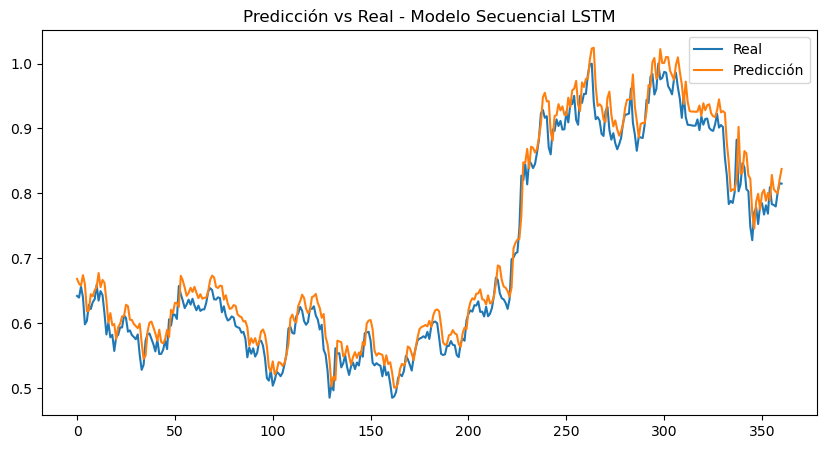

In [64]:
# Entrenamiento y evaluación de un ejemplo
# Ejemplo: modelo secuencial LSTM con 1 capa, 50 neuronas, usando RMSprop
model_seq = build_sequential_model(model_type='LSTM', n_steps=n_steps, n_features=1,
                                   n_units=50, n_layers=1, optimizer='rmsprop')
history_seq = model_seq.fit(X_train, y_train, epochs=50, batch_size=16, validation_split=0.1, verbose=0)

# Predicción y evaluación
predictions = model_seq.predict(X_test)
mse = mean_squared_error(y_test, predictions)
print("MAE modelo secuencial LSTM:", mse)

# Visualización
plt.figure(figsize=(10,5))
plt.plot(y_test, label='Real')
plt.plot(predictions, label='Predicción')
plt.title("Predicción vs Real - Modelo Secuencial LSTM")
plt.legend()
plt.show()

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
MAE modelo funcional GRU: 0.0004106464687507448


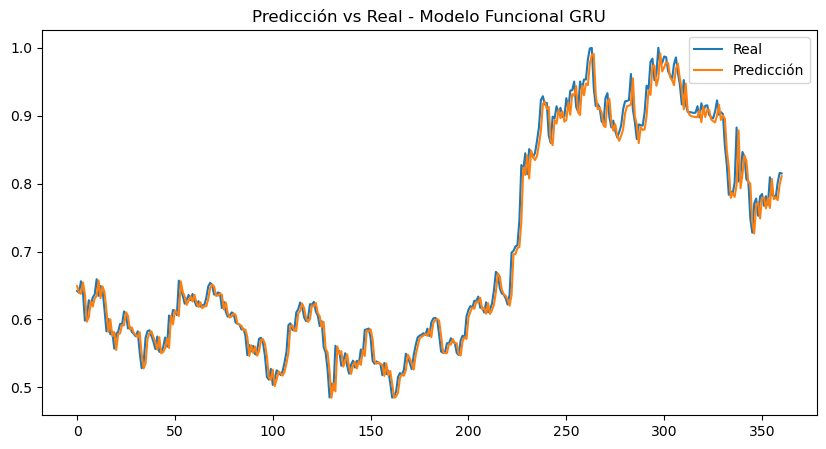

In [65]:
# Por ejemplo, construir un modelo funcional con GRU:
model_func = build_functional_model(model_type='GRU', n_steps=n_steps, n_features=1,
                                    n_units=50, n_layers=1, optimizer='adam')
history_func = model_func.fit(X_train, y_train, epochs=50, batch_size=16, validation_split=0.1, verbose=0)

predictions_func = model_func.predict(X_test)
mse_func = mean_squared_error(y_test, predictions_func)
print("MAE modelo funcional GRU:", mse_func)

plt.figure(figsize=(10,5))
plt.plot(y_test, label='Real')
plt.plot(predictions_func, label='Predicción')
plt.title("Predicción vs Real - Modelo Funcional GRU")
plt.legend()
plt.show()